In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
import tqdm
import h5py
import numpy as np
import tensorflow as tf
#import tensorflow_addons as tfa
import skimage.transform as st
import skimage.filters as sf
import matplotlib.pyplot as plt
%matplotlib inline
import cv2

In [2]:
# Select global values for the normalisation
min_value = 0.01
max_value = 0.90
npix = 192

In [3]:
# Gaussian smoothing of binned images
sigma_gauss = 0.0

# These give the lower and upper cut values for each map
min_feature = np.array([5.5,5.5,4.0,-0.5,-10.0,2.5])
max_feature = np.array([9.5,8.5,7.5,1.14,-1.5,6.5])
cut_feature = 10.**np.array([5.5,5.5,4.0,-0.5,-10.0,2.5])
min_feature[3] = 10.**min_feature[3]
max_feature[3] = 10.**max_feature[3]
min_feature[4] = 10.**min_feature[4]
max_feature[4] = 10.**max_feature[4]

In [4]:
max_label = -15.5
min_label = -21.5

# First the features

In [5]:
# Load file for features
image_file = h5py.File('C:/Users/simin/Documents/studium/Thesis/images_intrinsic_binned.h5','r')

# Get all systems (galaxies) in this file
system_names = list(image_file.keys())
print(f'System Names = {system_names}\n')


        
map_names = image_file[list(image_file.keys())[0]][list(image_file[list(image_file.keys())[0]].keys())[0]].attrs['Maps']
nmaps = len(map_names)

X = np.empty((0, npix, npix, nmaps))

for system_name in system_names:
    system = image_file[system_name]
    projection_names = list(system.keys())
    for projection_name in projection_names:
        # Get full image
        full_image = np.array(system[projection_name])
        # Clip the image values
        for i in range(nmaps): full_image[:,:,i] = np.where(full_image[:,:,i] < cut_feature[i], cut_feature[i], full_image[:,:,i])
        # Get log surface density
        full_image[:,:,0] = np.log10(full_image[:,:,0])
        full_image[:,:,1] = np.log10(full_image[:,:,1])
        full_image[:,:,2] = np.log10(full_image[:,:,2])
        full_image[:,:,5] = np.log10(full_image[:,:,5])
        # Normalize and Clip
        full_image = (full_image - min_feature) / (max_feature - min_feature) * (max_value - min_value) + min_value 
        full_image[full_image < min_value] = min_value
        full_image[full_image > max_value] = max_value
        # Resize
        full_image = st.resize(full_image,(npix,npix),order=3,anti_aliasing=True,preserve_range=True)
        # Combine
        X = np.concatenate([X, full_image.reshape(1, npix, npix, nmaps)], axis=0)
            

X = np.transpose(X, (0,2,1,3)).astype(np.float32)
print(X.shape, X.min(), X.max, X.mean)

image_file.close()

System Names = ['g1.08e11', 'g1.12e12', 'g1.37e11', 'g1.52e11', 'g1.59e11', 'g1.77e12', 'g1.92e12', 'g2.41e11', 'g2.42e11', 'g2.57e11', 'g2.79e12', 'g3.06e11', 'g3.49e11', 'g5.38e11', 'g6.96e11', 'g7.08e11', 'g7.55e11', 'g7.66e11', 'g8.13e11', 'g8.26e11']

(219, 192, 192, 6) 0.01 <built-in method max of numpy.ndarray object at 0x000001F7BDE487B0> <built-in method mean of numpy.ndarray object at 0x000001F7BDE487B0>


# And now the labels

In [6]:
# Load file for labels
image_file = h5py.File('C:/Users/simin/Documents/studium/Thesis/images_withdust_AB.h5','r')

# Get all systems (galaxies) in this file
system_names = list(image_file.keys())
print(f'System Names = {system_names}\n')


filter_names = image_file[list(image_file.keys())[0]][list(image_file[list(image_file.keys())[0]].keys())[0]].attrs['Filters']
nfilters = len(filter_names)

y = np.empty((0, npix, npix, nfilters))

for system_name in system_names:
    system = image_file[system_name]
    projection_names = list(system.keys())
    for projection_name in projection_names:
        # Get full image
        full_image = np.array(system[projection_name])
        # Clip the image values
        full_image = np.where(full_image < 10.**min_label, 10.**min_label, full_image)
        # Get log surface density
        full_image = np.log10(full_image)
        # Normalize and clip
        full_image = (full_image - min_label) / (max_label - min_label) * (max_value - min_value) + min_value 
        full_image[full_image < min_value] = min_value
        full_image[full_image > max_value] = max_value
        # Resize
        full_image = st.resize(full_image,(npix,npix),order=3,anti_aliasing=True,preserve_range=True)
        # Combine
        y = np.concatenate([y, full_image.reshape(1, npix, npix, nfilters)], axis=0)
              

y = np.transpose(y, (0,2,1,3)).astype(np.float32)
print(y.shape, y.min(), y.max, y.mean)

image_file.close()

System Names = ['g1.08e11', 'g1.12e12', 'g1.37e11', 'g1.52e11', 'g1.59e11', 'g1.77e12', 'g1.92e12', 'g2.41e11', 'g2.42e11', 'g2.57e11', 'g2.79e12', 'g3.06e11', 'g3.49e11', 'g5.38e11', 'g6.96e11', 'g7.08e11', 'g7.55e11', 'g7.66e11', 'g8.13e11', 'g8.26e11']

(219, 192, 192, 5) 0.01 <built-in method max of numpy.ndarray object at 0x000001F7C4B57300> <built-in method mean of numpy.ndarray object at 0x000001F7C4B57300>


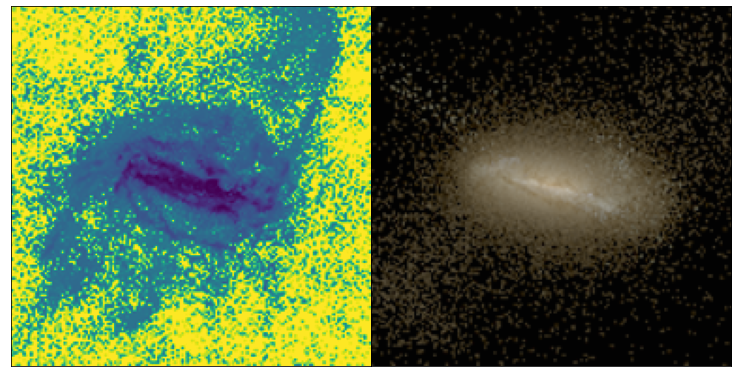

In [7]:
nr = 172
mm = 5

plt.figure(figsize=(10,20))

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

ax1.imshow(X[nr,:,:,mm], vmin=min_value, vmax=max_value)
ax2.imshow(np.transpose(y[nr],(0,1,2))[:,:,[2,1,0]], vmin=min_value, vmax=max_value)

for ax in [ax1,ax2]:
    ax.tick_params(labelleft=False, labelbottom=False, labeltop=False, labelright=False)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0, hspace=0.0, wspace=0.0)

# building U-Net Model

In [8]:
width = 192
height = 192
channels = 6

In [9]:
inputs = tf.keras.layers.Input((width, height, channels))

In [10]:
#s = tf.keras.layers.Lambda(lambda x: x/255)(inputs)

# Encoding path


c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
c1 = tf.keras.layers.Dropout(0.1)(c1)
c1 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
p1 = tf.keras.layers.MaxPool2D((2, 2))(c1)

c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
c2 = tf.keras.layers.Dropout(0.1)(c2)
c2 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
p2 = tf.keras.layers.MaxPool2D((2, 2))(c2)

c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
c3 = tf.keras.layers.Dropout(0.2)(c3)
c3 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
p3 = tf.keras.layers.MaxPool2D((2, 2))(c3)

c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
c4 = tf.keras.layers.Dropout(0.2)(c4)
c4 = tf.keras.layers.Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
p4 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c4)

#c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
#c5 = tf.keras.layers.Dropout(0.2)(c5)
#c5 = tf.keras.layers.Conv2D(512, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
#p5 = tf.keras.layers.MaxPool2D(pool_size=(2, 2))(c5)


In [11]:
# Decoding path


u6 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(1, 1), padding='same')(c4)
u6 = tf.keras.layers.concatenate([u6, c4])
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
c6 = tf.keras.layers.Dropout(0.2)(c6)
c6 = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

u7 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
u7 = tf.keras.layers.concatenate([u7, c3])
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
c7 = tf.keras.layers.Dropout(0.2)(c7)
c7 = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

u8 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
u8 = tf.keras.layers.concatenate([u8, c2])
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
c8 = tf.keras.layers.Dropout(0.1)(c8)
c8 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)

u9 = tf.keras.layers.Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c8)
u9 = tf.keras.layers.concatenate([u9, c1])
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
c9 = tf.keras.layers.Dropout(0.1)(c9)
c9 = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)

In [12]:
outputs = tf.keras.layers.Conv2D(5, (3,3), activation='sigmoid', padding='same')(c9)

In [13]:
print('Inputs shape: ', inputs.shape)
print('Output shape: ', outputs.shape)

Inputs shape:  (None, 192, 192, 6)
Output shape:  (None, 192, 192, 5)


In [14]:
model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
optimizer = tf.keras.optimizers.Adam(lr=0.001)
model.compile(optimizer=optimizer, loss='MSE')
model.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 192, 6) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 192, 32) 1760        input_1[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 192, 192, 32) 0           conv2d[0][0]                     
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 192, 32) 9248        dropout[0][0]                    
_______________________________________________________________________________________

In [71]:
#model.save()
checkpointer = tf.keras.callbacks.ModelCheckpoint('model.h5', verbose = 1, save_best_only = True)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('model.{epoch:03d}-{val_loss:.6f}.h5', monitor = 'val_loss', save_best_only = True, save_weights_only = True) 
    tf.keras.callbacks.EarlyStopping(patience = 10, monitor = 'val_loss'),
    tf.keras.callbacks.TensorBoard(log_dir = 'logs')
]

In [72]:
results = model.fit(X,y, validation_split=0.20, batch_size=25, epochs=350, callbacks=callbacks)

Epoch 1/350
7/7 [==============================] - 66s 9s/step - loss: 0.0035 - val_loss: 0.0033
Epoch 2/350
7/7 [==============================] - 66s 9s/step - loss: 0.0034 - val_loss: 0.0033
Epoch 3/350
7/7 [==============================] - 64s 9s/step - loss: 0.0034 - val_loss: 0.0032
Epoch 4/350
7/7 [==============================] - 65s 9s/step - loss: 0.0033 - val_loss: 0.0029
Epoch 5/350
7/7 [==============================] - 65s 9s/step - loss: 0.0033 - val_loss: 0.0031
Epoch 6/350
7/7 [==============================] - 65s 9s/step - loss: 0.0032 - val_loss: 0.0029
Epoch 7/350
7/7 [==============================] - 62s 9s/step - loss: 0.0032 - val_loss: 0.0029
Epoch 8/350
7/7 [==============================] - 65s 9s/step - loss: 0.0031 - val_loss: 0.0030
Epoch 9/350
7/7 [==============================] - 64s 9s/step - loss: 0.0031 - val_loss: 0.0032
Epoch 10/350
7/7 [==============================] - 65s 9s/step - loss: 0.0030 - val_loss: 0.0036
Epoch 11/350
7/7 [===========

In [73]:
y_pre = model.predict(X)

In [74]:
print(y_pre.shape)

(219, 192, 192, 5)


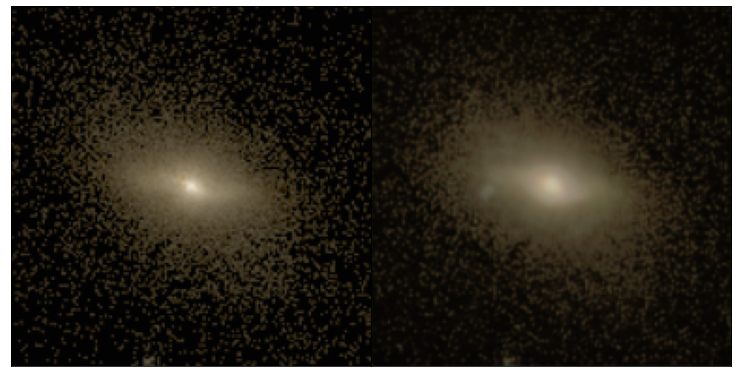

In [75]:
nr = 20
mm = 2

plt.figure(figsize=(10,20))

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

#ax1.imshow(X[nr,:,:,mm], vmin=min_value, vmax=max_value)
ax1.imshow(np.transpose(y[nr],(0,1,2))[:,:,[2,1,0]], vmin=min_value, vmax=max_value)
ax2.imshow(np.transpose(y_pre[nr],(0,1,2))[:,:,[2,1,0]], vmin=min_value, vmax=max_value)

for ax in [ax1,ax2]:
    ax.tick_params(labelleft=False, labelbottom=False, labeltop=False, labelright=False)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0, hspace=0.0, wspace=0.0)

In [76]:
results = model.fit(X,y, validation_split=0.20, batch_size=10, epochs=350, callbacks=callbacks)

Epoch 1/350
18/18 [==============================] - 55s 3s/step - loss: 0.0021 - val_loss: 0.0021
Epoch 2/350
18/18 [==============================] - 65s 4s/step - loss: 0.0021 - val_loss: 0.0020
Epoch 3/350
18/18 [==============================] - 72s 4s/step - loss: 0.0021 - val_loss: 0.0019
Epoch 4/350
18/18 [==============================] - 79s 4s/step - loss: 0.0020 - val_loss: 0.0018
Epoch 5/350
18/18 [==============================] - 76s 4s/step - loss: 0.0021 - val_loss: 0.0025
Epoch 6/350
18/18 [==============================] - 78s 4s/step - loss: 0.0021 - val_loss: 0.0018
Epoch 7/350
18/18 [==============================] - 76s 4s/step - loss: 0.0021 - val_loss: 0.0020
Epoch 8/350
18/18 [==============================] - 75s 4s/step - loss: 0.0020 - val_loss: 0.0018
Epoch 9/350
18/18 [==============================] - 75s 4s/step - loss: 0.0021 - val_loss: 0.0018
Epoch 10/350
18/18 [==============================] - 76s 4s/step - loss: 0.0021 - val_loss: 0.0018
Epoch 11/

18/18 [==============================] - 62s 3s/step - loss: 0.0015 - val_loss: 0.0014
Epoch 84/350
18/18 [==============================] - 59s 3s/step - loss: 0.0015 - val_loss: 0.0014
Epoch 85/350
18/18 [==============================] - 59s 3s/step - loss: 0.0015 - val_loss: 0.0014
Epoch 86/350
18/18 [==============================] - 60s 3s/step - loss: 0.0015 - val_loss: 0.0015
Epoch 87/350
18/18 [==============================] - 62s 3s/step - loss: 0.0015 - val_loss: 0.0015
Epoch 88/350
18/18 [==============================] - 64s 4s/step - loss: 0.0015 - val_loss: 0.0015
Epoch 89/350
18/18 [==============================] - 65s 4s/step - loss: 0.0015 - val_loss: 0.0015
Epoch 90/350
18/18 [==============================] - 63s 4s/step - loss: 0.0015 - val_loss: 0.0015
Epoch 91/350
18/18 [==============================] - 63s 3s/step - loss: 0.0015 - val_loss: 0.0015
Epoch 92/350
18/18 [==============================] - 67s 4s/step - loss: 0.0014 - val_loss: 0.0014


In [77]:
y_pre = model.predict(X)

In [78]:
print(y_pre.shape)

(219, 192, 192, 5)


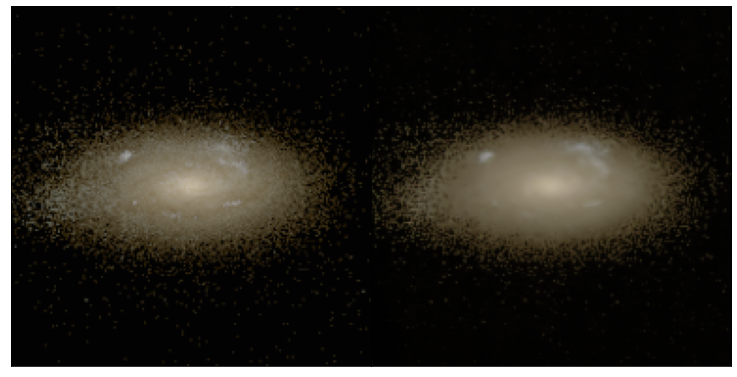

In [94]:
nr = 104
mm = 5

plt.figure(figsize=(10,20))

ax1 = plt.subplot(1,2,1)
ax2 = plt.subplot(1,2,2)

#ax1.imshow(X[nr,:,:,mm], vmin=min_value, vmax=max_value)
ax1.imshow(np.transpose(y[nr],(0,1,2))[:,:,[2,1,0]], vmin=min_value, vmax=max_value)
ax2.imshow(np.transpose(y_pre[nr],(0,1,2))[:,:,[2,1,0]], vmin=min_value, vmax=max_value)

for ax in [ax1,ax2]:
    ax.tick_params(labelleft=False, labelbottom=False, labeltop=False, labelright=False)
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(left=0.0, right=1.0, bottom=0.0, top=1.0, hspace=0.0, wspace=0.0)

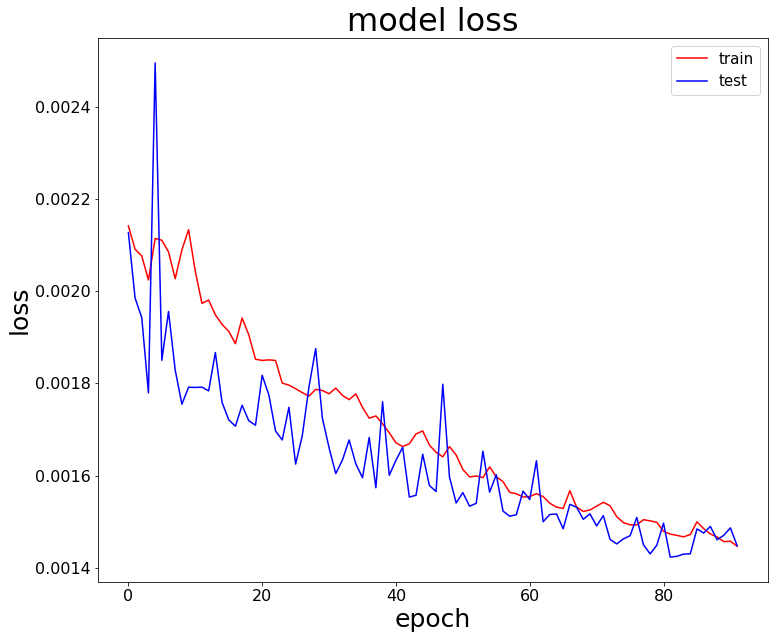

In [161]:

plt.figure(figsize=(12,10))
plt.plot(results.history['loss'], color='red')
plt.plot(results.history['val_loss'], color='blue')
plt.title('model loss', fontsize=32)
plt.ylabel('loss', fontsize=25)
plt.xlabel('epoch', fontsize=25)
plt.rc('xtick',labelsize=16)
plt.rc('ytick',labelsize=16)
plt.legend(['train', 'test'], loc='upper right', fontsize=15)

plt.show()